# Perform Classification on the ADNI dataset

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.interpolate import interp1d

### Read the data:

Instead of reading the whole database, we read only the data that's useful to us. That is, we read only specific columns of data, and we take only the row containing the first scan for each person. 

In "ADNI Regressional Analysis.ipynb" we have done that exactly, as well as performed linear regression transformation to the imaging data, in order to remove any age, sex, and DLICV_baseline effect. 

Furthermore, in "ADNI OPNMF.ipynb" we have performed dimensionality reduction through the OPNMF method, reducing the number of the ROIs from 145 to just 18. (Hasn't been done, so this does not apply)

Additionally, in "ADNI DeepCCA initial.ipynb" we have transformed the imaging and the genetic data using Deep Canonical Correlation Analysis to dimensionally reduced, maximally linearly correlated data. 

The data is located at "./DATA/ADNI_dataset.csv"
The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl"
The further transormed (through DCCA) data is located at "./DATA/ADNI_initial_DCCA_features.pkl"

(Need to run the RA and DCCA code if data is not found)

In [7]:
# Read the original data:
data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning
data.replace({'Sex':{'F':1, 'M':0}}, inplace=True)

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'Date',
                       'Age', 
                       'Sex',
                       'DLICV_baseline',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns

# Need the dropna because some first PTIDs have no MRI
data_of_interest = data[columns_of_interest].dropna(subset=['MUSE_Volume_4', 'DLICV_baseline'])


unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
u = unique.dropna() # only 2 values in Diagnosis_nearest_2.0' have NaN, easier to drop them:
unique = u
print(unique.shape)
unique.head(15)

(1567, 207)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1873.124153,1586.249283,...,0,1,1,1,0,0,0,0,0,1
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,2131.516933,1505.034469,...,1,0,1,1,0,1,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,2366.717680,3157.732947,...,2,0,0,0,0,1,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,5124.734093,2981.605944,...,1,0,0,0,1,1,0,0,0,2
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2941.520445,1693.826402,...,2,1,1,1,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,966.095170,1921.643449,...,1,0,0,0,1,1,0,0,0,1
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1427.160586,1604.163157,...,0,0,0,0,0,1,0,0,0,2
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1931.131939,1136.952611,...,0,0,1,1,0,1,0,0,0,0
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,707.696352,2621.956978,...,2,2,1,1,0,1,0,0,0,1
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,2681.014413,1374.257191,...,1,1,0,0,0,1,0,0,0,1


In [8]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head(15)

(1567, 207)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-440.777069,-507.297168,...,0,1,1,1,0,0,0,0,0,1
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,577.755137,-188.813792,...,1,0,1,1,0,1,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,198.499249,1080.290951,...,2,0,0,0,0,1,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2623.687012,649.558822,...,1,0,0,0,1,1,0,0,0,2
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,727.400228,-250.782773,...,2,1,1,1,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,246.226215,628.340793,...,1,0,0,0,1,1,0,0,0,1
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-145.138564,-193.593195,...,0,0,0,0,0,1,0,0,0,2
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,169.421397,-610.085153,...,0,0,1,1,0,1,0,0,0,0
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-81.664210,1343.833768,...,2,2,1,1,0,1,0,0,0,1
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1036.385233,-353.324662,...,1,1,0,0,0,1,0,0,0,1


In [9]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
dcca_data = lr_data.drop(labels = columns_to_drop, axis=1)

# Read the data transformed through DCCA:
with open("./DATA/ADNI_initial_DCCA_features.pkl", 'rb') as f:
    dcca_transformed_data_file = pickle.load(f)
transformed_imaging_data = dcca_transformed_data_file[0]
transformed_genetic_data = dcca_transformed_data_file[1]
print("Transformed imaging data dimensions: \n" , transformed_imaging_data.shape)
print("Transformed genetic data dimensions: \n" , transformed_genetic_data.shape)

# Embed them into the new dataset:
imaging_labels = ["imaging_component_"+str(x+1) for x in range(transformed_imaging_data.shape[1])] 
genetic_labels = ["genetic_component_"+str(x+1) for x in range(transformed_genetic_data.shape[1])] 
dcca_data[genetic_labels] = transformed_genetic_data
dcca_data[imaging_labels] = transformed_imaging_data
print("DCCA Data Dimensions: \n",dcca_data.shape)
dcca_data.head(15)

Transformed imaging data dimensions: 
 (1567, 25)
Transformed genetic data dimensions: 
 (1567, 25)
DCCA Data Dimensions: 
 (1567, 58)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,genetic_component_1,genetic_component_2,...,imaging_component_16,imaging_component_17,imaging_component_18,imaging_component_19,imaging_component_20,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1.739633,0.030259,...,0.266387,0.864024,2.455733,-2.709755,0.541651,1.392345,-0.153042,-2.356390,0.160205,-1.063649
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0.345532,-1.103427,...,-1.636223,-1.206294,0.510578,0.971868,0.465067,0.119577,1.183522,1.152912,3.032454,1.289266
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,-0.186543,-0.289961,...,0.036899,0.094559,-0.079973,-1.252175,-0.034416,-0.654089,0.984064,-1.719628,0.437506,-0.482572
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,0.651392,2.065969,...,-1.325914,-0.142220,-0.010059,-1.105924,0.909221,0.956359,0.060368,1.655335,-1.152360,-0.447221
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2.138471,0.253546,...,-0.523639,-1.040973,-0.585231,-0.267127,0.360686,-0.301348,-0.094476,-1.147852,-0.824456,1.009487
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,-0.630891,1.623473,...,1.024569,-0.890471,0.761611,0.095821,1.396309,-1.110488,0.286247,0.027128,0.240418,1.309746
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-0.921068,-1.519832,...,0.992400,-0.239545,0.545574,1.241381,-0.784372,1.678289,0.664180,0.605062,-0.593888,0.421225
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,-0.492949,0.392816,...,0.629573,-0.873071,1.447603,-1.739018,0.765706,-0.918259,-1.551159,2.288036,0.697659,1.038455
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-0.177824,1.574392,...,-1.434573,0.598178,0.861695,-0.645816,0.575668,-1.450028,0.233787,0.520621,0.634936,2.234361
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1.593849,-0.388852,...,0.312316,0.240235,0.258327,-1.285525,1.629622,0.015490,-0.840134,-1.783537,1.343228,-0.010991


### Perform Classification using SVMs:

WITHOUT DCCA:
Accuracy (Linear Kernel):  55.73
F1 (Linear Kernel):  52.07
Accuracy (Polynomial Kernel):  54.14
F1 (Polynomial Kernel):  43.94
Accuracy (RBF Kernel):  55.73
F1 (RBF Kernel):  52.07
WITH DCCA:


/opt/homebrew/Caskroom/miniconda/base/envs/DeepCCA/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy (Linear Kernel):  50.96
F1 (Linear Kernel):  41.91
Accuracy (Polynomial Kernel):  52.55
F1 (Polynomial Kernel):  36.83
Accuracy (RBF Kernel):  52.87
F1 (RBF Kernel):  36.91


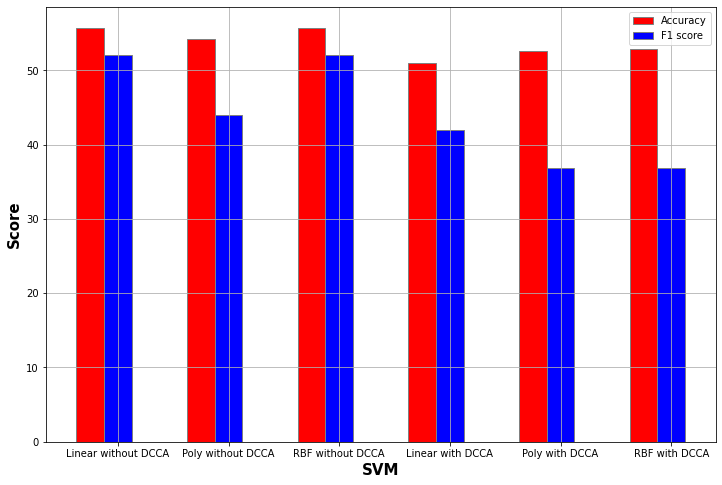

In [13]:
##############################################  on LR data (without DCCA):
print("WITHOUT DCCA:")
# Get the values that interest us:
X = lr_data[MRI_columns + genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0"]

# Perform train-test split:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, shuffle=False)

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin  = svm.SVC().fit(X_train, Y_train)
rbf  = svm.SVC(kernel='rbf').fit(X_train, Y_train)
poly = svm.SVC(kernel='poly').fit(X_train, Y_train)

# Predict:
lin_pred  = lin.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred  = rbf.predict(X_test)
lin_accuracy = accuracy_score(Y_test, lin_pred)
lin_f1 = f1_score(Y_test, lin_pred, average='weighted')
print('Accuracy (Linear Kernel): ', "%.2f" % (lin_accuracy*100))
print('F1 (Linear Kernel): ', "%.2f" % (lin_f1*100))
poly_accuracy = accuracy_score(Y_test, poly_pred)
poly_f1 = f1_score(Y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
rbf_accuracy = accuracy_score(Y_test, rbf_pred)
rbf_f1 = f1_score(Y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

############################################## on LR data (with DCCA):
print("WITH DCCA:")
# Get the values that interest us:
X_d= dcca_data[genetic_labels + imaging_labels]
Y_d = dcca_data["Diagnosis_nearest_2.0"]

# Perform train-test split:
X_train_d, X_test_d, Y_train_d, Y_test_d = model_selection.train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)

# Create 3 separate kernels for experimentation:
lin_d = svm.LinearSVC().fit(X_train_d, Y_train_d)
rbf_d  = svm.SVC(kernel='rbf').fit(X_train_d, Y_train_d)
poly_d = svm.SVC(kernel='poly').fit(X_train_d, Y_train_d)

# Predict:
lin_pred_d  = lin_d.predict(X_test_d)
poly_pred_d = poly_d.predict(X_test_d)
rbf_pred_d  = rbf_d.predict(X_test_d)
lin_accuracy_d = accuracy_score(Y_test_d, lin_pred_d)
lin_f1_d = f1_score(Y_test_d, lin_pred_d, average='weighted')
print('Accuracy (Linear Kernel): ', "%.2f" % (lin_accuracy_d*100))
print('F1 (Linear Kernel): ', "%.2f" % (lin_f1_d*100))
poly_accuracy_d = accuracy_score(Y_test_d, poly_pred_d)
poly_f1_d = f1_score(Y_test_d, poly_pred_d, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy_d*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1_d*100))
rbf_accuracy_d = accuracy_score(Y_test_d, rbf_pred_d)
rbf_f1_d = f1_score(Y_test_d, rbf_pred_d, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy_d*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1_d*100))

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
Accuracies = [lin_accuracy,poly_accuracy,rbf_accuracy,lin_accuracy_d,poly_accuracy_d,rbf_accuracy_d]
F1s = [lin_f1,poly_f1,rbf_f1,lin_f1_d,poly_f1_d,rbf_f1_d]
 
# Set position of bar on X axis
br1 = np.arange(len(Accuracies))
br2 = [x + barWidth for x in br1]

 
# Make the plot
plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth,
        edgecolor ='grey', label ='Accuracy')
plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth,
        edgecolor ='grey', label ='F1 score')
 
# Adding Xticks
plt.xlabel('SVM', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Accuracies))],
        ['Linear without DCCA', 'Poly without DCCA', 'RBF without DCCA', 
         'Linear with DCCA', 'Poly with DCCA', 'RBF with DCCA'])
plt.grid()
plt.legend()
plt.show()

### Perform Classification using kNN:

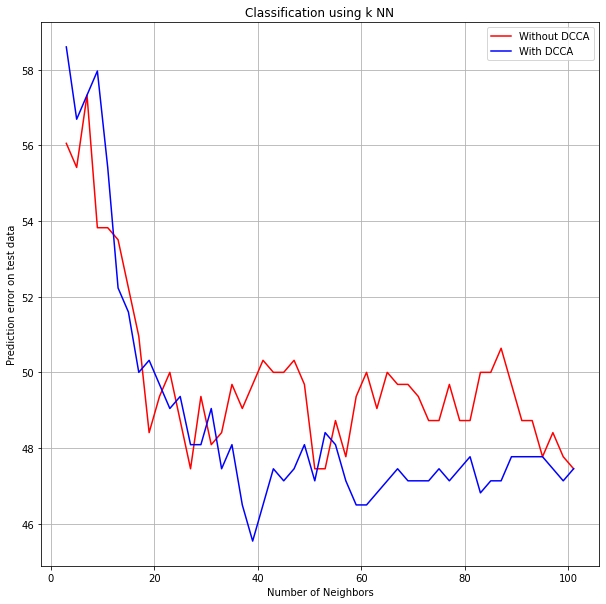

In [14]:
accs = []
accs_d = []
neighbors = [x for x in range(3,103,2)]
for nn in neighbors:
    knn = KNeighborsClassifier(n_neighbors=nn)
#     print("Number of neighbors: ", nn)

    #  on LR data (without DCCA):

    # Get the values that interest us:
    X = lr_data[MRI_columns + genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0"]

    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, shuffle=False)

    # Train:
    knn.fit(X_train, Y_train)

    # Predict:
    acc = knn.score(X_test, Y_test)
    accs.append(100 - acc*100)
#     print("WITHOUT DCCA:",'Accuracy: ', "%.2f" % (acc*100))


    # on LR data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels + imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0"]

    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = model_selection.train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)

    # Train:
    knn.fit(X_train_d, Y_train_d)

    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d.append(100 - acc_d*100)
# #     print("WITH DCCA:",'Accuracy: ', "%.2f" % (acc*100))
    
#     print("-------------------------------------------------------------------------------","\n")

plt.figure(figsize=(10,10))
plt.plot(neighbors, accs, color='r', label="Without DCCA")
plt.plot(neighbors, accs_d, color='b', label="With DCCA")
plt.grid()
plt.legend()
plt.title("Classification using k NN")
plt.ylabel("Prediction error on test data")
plt.xlabel("Number of Neighbors")
plt.show()